# Homework - Deep learning for image classification


Let's train network to classify images from Tiny ImageNet!

Your homework contains three parts:

1. Make yourself familiar with ordinary training script structure and train good old vgg-like network
2. Improve quality with resnet-like network
3. Improve quality with test-time augmentation

But first of all let's take a look on data

# Tiny ImageNet dataset
In this homework we shall focus on the image recognition problem on Tiny Image Net dataset. This dataset contains
* 100k images of shape 3x64x64
* 200 different classes: snakes, spiders, cats, trucks, grasshopper, gull, etc.

In fact, it is a subset of ImageNet dataset with 4x downscaled images.

## Image examples



<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim3.png?raw=1" alt="Drawing" style="width:90%"/> </td>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim2.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>


<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tiniim.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>

## Step 0 - data loading

In [1]:
#!S:bash
# if you are in colab, just add '!' in the start of the following line
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

--2023-05-01 00:13:27--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 813 [text/plain]
Saving to: ‘tiny_img.py’

tiny_img.py         100%[===================>]     813  --.-KB/s    in 0s      

2023-05-01 00:13:27 (44,2 MB/s) - ‘tiny_img.py’ saved [813/813]

--2023-05-01 00:13:27--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response

In [2]:
#!L
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

Dataset was already downloaded to './tiny-imagenet-200.zip'. Skip downloading
Extract downloaded dataset to '.'


## Part 1. Training script structure and vgg-like network

In order to train a neural network for a specific task you should write code for 4 task-specific blocks and for one task-independed block:
1. data loader (data provider) - how to load and augment data for nn training
2. neural network architecture - what will be trained
3. loss function (+ auxilary metrics on train and validation set) - how to check neural network quality
4. optiimzer and training schedule - how neural network will be trained
5. "Train loop" - what exactly to do for each batch, how often to check validation error, how often to save network and so on. This code could be written in general way and reused between different training scripts


In [3]:
import torch
import torchvision
from torchvision import transforms
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


### 1.1 Data loader and data augmentation
Normally there are two connected abstractions for data manipulation:
- Dataset (`torch.utils.data.Dataset` and its subclasses from `torchvision.datasets`) - some black-box that keeps and preprocesses separate elements of dataset. In particular, single sample augmentations live on this level usually.
- DataLoader (`torch.utils.data.DataLoader`) - structure that combines separate elements in batch.

Let's deal with training dataset. Here are some simple augmentations that we are going to use in our experiments:

In [58]:
# Try AutoAugment here
train_transforms = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
     transforms.RandomResizedCrop((64, 64), ratio = (0.9, 1.1), scale=(0.7, 1.0),
        interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
     transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5)),
     transforms.ElasticTransform(alpha=50.0, sigma=5.0),
     # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),    
    ]
)

For training dataset we will use custom dataset that will keep all training data in RAM. If your amount of RAM memory is low, you can use `torchvision.datasets.ImageFolder()` instead.

In [4]:
train_transforms = train_transforms = transforms.Compose(
    [transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.IMAGENET),
     transforms.ToTensor()]
)

In [5]:
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset 
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_transforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


Now validation. Take a look at `tiny-imagenet-200/val` folder and compare it with `tiny-imagenet-200/train`. Looks different, right? So we can't use `TinyImagenetRAM` for loading the validation set. Let's write a custom dataset instead but with the same behavior like `TinyImagenetRAM`.

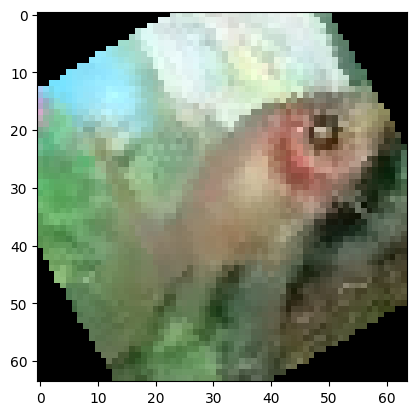

In [6]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[0][0].permute(1,2,0))

In [7]:
from torch.utils.data import Dataset
import os
from PIL import Image

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        # 1. define self.classes - list of sorted class labels from annotations
        # it should look like self.classes from "TinyImagenetRAM"
        self.classes = sorted(set(i[1] for i in annotations))
        
        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        # 2. self.class_to_idx - dict from class label to class index
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
            # store the class index in self.targets
            image = tiny_img_dataset.read_rgb_image(img_name)
            
            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # take image and its target label from "self.images" and "self.targets", 
        # transform the image using self.transform and return the transformed image and its target label
        image = self.images[index]
        image = self.transform(image)
        target = self.targets[index]

        return image, target

Let's finally load validation dataset. Normally you don't need to augment validation data.

In [8]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:04<00:00, 2306.39it/s]


For the most cases the default `DataLoader` will be good enough.

In [9]:
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=2)

In [10]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=2)

### 1.2 Neural network definition

"VGG-like network" usually means that the network is a sequence of convolutions with MaxPooling for downsampling. Here is a table from the original paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556) that describes classical configurations of VGG networks (often referred as VGG-A, VGG-B and so on using column name as an identificator or as VGG16, VGG19 and so on using amount of layers as an identificator)
![image.png](https://pytorch.org/assets/images/vgg.png)

These network configurations were designed for ImageNet dataset. Since images in tiny-imagenet are 4x downsampled, we are going to design our own configuration by reducing: 1) amount of layers; 2) amount of neurons in layers; 3) amount of maxpooling layers which downsample feature maps

Our network config will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

We use Conv(128) and GlobalAveragePooling instead of image flattening and FC layers for reducing the amount of parameters. 

In [11]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

And one more thing. VGG was designed before BatchNormalization was introduced. Nowadays it will be stupid if we don't use batch normalization in our network. So let's define simple module containing convolution, batch norm and relu in it and build our network using this module. Here is also implementation of GlobalAveragePooling given for you as example of custom module.

In [12]:
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)

    
class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super().__init__()
        
        # define vars for convolution, batchnorm, relu
        
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        # sequentially apply convolution, batchnorm, relu to 'x'
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
    
def create_vgg_like_network(config=None):
    """
    Creates VGG like network according to config
    """
    model = nn.Sequential()
    
    default_config = [[16,16], [32, 32], [64, 64], [128, 128]]
    config = config or default_config
    
    in_channels = 3
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]
            
            # add ConvBNRelu module to model
            model.add_module(f"cbr_{block_index}_{layer_index_in_block}", ConvBNRelu(in_channels, out_channels, kernel_size=3))
            
            in_channels = out_channels
            
        if block_index != len(config) - 1:
            model.add_module(f'mp_{block_index}', nn.MaxPool2d(3, stride=2))
            
    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Here are our model created!

In [13]:
model = create_vgg_like_network()
model = model.to(device)

### 1.3 Loss function definition

Usually cross-entropy (negative log-likelihood) is used as loss function for image classification.

In [14]:
def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

### 1.4 Optimizer and training schedule

Let's train our network using Adam with default parameters. 

For training by `torch.optim.SGD` you usually have to define training schedule - a way how to decrease learning rate during training. But since in adam all the gradients are scaled on their second momentum, the effect of a good training schedule is not so critical for training as in SGD. So we are going to act like lazy data scientists and will not decrease learning rate at all. But you may play with scheduling using for example `torch.optim.lr_scheduler.ExponentialLR`, see the [documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) with explanation how to use it.

In [15]:
# TODO: check out the schedulers
opt = torch.optim.Adam(model.parameters())

### 1.5 Training loop

Let's combine the previously defined things together.

In [16]:
import numpy as np
import time


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

            
def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        opt.zero_grad()

        # forward
        # move X_batch, y_batch to 'device', 
        # compute model outputs on X_batch, 
        # run `compute_loss()` function
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)
        loss = compute_loss(predictions, y_batch)

        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train_model(model, optimizer, train_data_generator)
        
        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

### 1.6 Training

All the preparation is done, time to run the training!

Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy here. 

In [17]:
# Autoaugment
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [00:37<00:00, 41.97it/s]


Epoch 1 of 30 took 38.853s
  training loss (in-iteration): 	4.651290
  validation accuracy: 			8.99 %


100%|██████████| 1563/1563 [00:34<00:00, 44.91it/s]


Epoch 2 of 30 took 36.245s
  training loss (in-iteration): 	4.069419
  validation accuracy: 			15.50 %


100%|██████████| 1563/1563 [00:34<00:00, 45.70it/s]


Epoch 3 of 30 took 35.653s
  training loss (in-iteration): 	3.779707
  validation accuracy: 			19.99 %


100%|██████████| 1563/1563 [00:34<00:00, 44.94it/s]


Epoch 4 of 30 took 36.364s
  training loss (in-iteration): 	3.583739
  validation accuracy: 			20.18 %


100%|██████████| 1563/1563 [00:35<00:00, 43.88it/s]


Epoch 5 of 30 took 37.113s
  training loss (in-iteration): 	3.440500
  validation accuracy: 			27.38 %


100%|██████████| 1563/1563 [00:35<00:00, 44.41it/s]


Epoch 6 of 30 took 36.654s
  training loss (in-iteration): 	3.326960
  validation accuracy: 			29.00 %


100%|██████████| 1563/1563 [00:34<00:00, 44.92it/s]


Epoch 7 of 30 took 36.210s
  training loss (in-iteration): 	3.233892
  validation accuracy: 			29.85 %


100%|██████████| 1563/1563 [00:34<00:00, 44.99it/s]


Epoch 8 of 30 took 36.260s
  training loss (in-iteration): 	3.152767
  validation accuracy: 			27.37 %


100%|██████████| 1563/1563 [00:34<00:00, 44.74it/s]


Epoch 9 of 30 took 36.383s
  training loss (in-iteration): 	3.077873
  validation accuracy: 			32.40 %


100%|██████████| 1563/1563 [00:35<00:00, 43.85it/s]


Epoch 10 of 30 took 37.085s
  training loss (in-iteration): 	3.013783
  validation accuracy: 			32.99 %


100%|██████████| 1563/1563 [00:36<00:00, 42.86it/s]


Epoch 11 of 30 took 38.089s
  training loss (in-iteration): 	2.962275
  validation accuracy: 			34.76 %


100%|██████████| 1563/1563 [00:35<00:00, 43.49it/s]


Epoch 12 of 30 took 37.438s
  training loss (in-iteration): 	2.914690
  validation accuracy: 			34.48 %


100%|██████████| 1563/1563 [00:35<00:00, 44.11it/s]


Epoch 13 of 30 took 36.924s
  training loss (in-iteration): 	2.868168
  validation accuracy: 			34.28 %


100%|██████████| 1563/1563 [00:35<00:00, 44.03it/s]


Epoch 14 of 30 took 37.089s
  training loss (in-iteration): 	2.832640
  validation accuracy: 			35.66 %


100%|██████████| 1563/1563 [00:35<00:00, 44.30it/s]


Epoch 15 of 30 took 36.763s
  training loss (in-iteration): 	2.790725
  validation accuracy: 			37.87 %


100%|██████████| 1563/1563 [00:35<00:00, 44.04it/s]


Epoch 16 of 30 took 36.944s
  training loss (in-iteration): 	2.759280
  validation accuracy: 			36.81 %


100%|██████████| 1563/1563 [00:34<00:00, 44.98it/s]


Epoch 17 of 30 took 36.111s
  training loss (in-iteration): 	2.733551
  validation accuracy: 			36.50 %


100%|██████████| 1563/1563 [00:35<00:00, 43.98it/s]


Epoch 18 of 30 took 37.086s
  training loss (in-iteration): 	2.704723
  validation accuracy: 			38.08 %


100%|██████████| 1563/1563 [00:35<00:00, 43.72it/s]


Epoch 19 of 30 took 37.267s
  training loss (in-iteration): 	2.674960
  validation accuracy: 			38.68 %


100%|██████████| 1563/1563 [00:35<00:00, 43.73it/s]


Epoch 20 of 30 took 37.244s
  training loss (in-iteration): 	2.647623
  validation accuracy: 			38.55 %


100%|██████████| 1563/1563 [00:35<00:00, 43.89it/s]


Epoch 21 of 30 took 37.119s
  training loss (in-iteration): 	2.625261
  validation accuracy: 			38.05 %


100%|██████████| 1563/1563 [00:35<00:00, 43.98it/s]


Epoch 22 of 30 took 37.031s
  training loss (in-iteration): 	2.600611
  validation accuracy: 			40.67 %


100%|██████████| 1563/1563 [00:35<00:00, 44.26it/s]


Epoch 23 of 30 took 36.828s
  training loss (in-iteration): 	2.584126
  validation accuracy: 			38.40 %


100%|██████████| 1563/1563 [00:35<00:00, 44.08it/s]


Epoch 24 of 30 took 36.987s
  training loss (in-iteration): 	2.559805
  validation accuracy: 			39.91 %


100%|██████████| 1563/1563 [00:35<00:00, 43.99it/s]


Epoch 25 of 30 took 37.011s
  training loss (in-iteration): 	2.552333
  validation accuracy: 			40.29 %


100%|██████████| 1563/1563 [00:36<00:00, 42.41it/s]


Epoch 26 of 30 took 38.477s
  training loss (in-iteration): 	2.523795
  validation accuracy: 			39.33 %


100%|██████████| 1563/1563 [00:37<00:00, 42.12it/s]


Epoch 27 of 30 took 38.568s
  training loss (in-iteration): 	2.503710
  validation accuracy: 			41.26 %


100%|██████████| 1563/1563 [00:36<00:00, 43.20it/s]


Epoch 28 of 30 took 37.576s
  training loss (in-iteration): 	2.488344
  validation accuracy: 			41.11 %


100%|██████████| 1563/1563 [00:35<00:00, 43.64it/s]


Epoch 29 of 30 took 37.374s
  training loss (in-iteration): 	2.472022
  validation accuracy: 			39.72 %


100%|██████████| 1563/1563 [00:36<00:00, 42.73it/s]


Epoch 30 of 30 took 38.097s
  training loss (in-iteration): 	2.459137
  validation accuracy: 			41.24 %


In [71]:
# Better transforms
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [07:21<00:00,  3.54it/s]


Epoch 1 of 30 took 442.114s
  training loss (in-iteration): 	4.614799
  validation accuracy: 			8.90 %


100%|██████████| 1563/1563 [07:21<00:00,  3.54it/s]


Epoch 2 of 30 took 442.762s
  training loss (in-iteration): 	4.039064
  validation accuracy: 			12.31 %


100%|██████████| 1563/1563 [07:21<00:00,  3.54it/s]


Epoch 3 of 30 took 442.198s
  training loss (in-iteration): 	3.749279
  validation accuracy: 			16.64 %


100%|██████████| 1563/1563 [07:23<00:00,  3.53it/s]


Epoch 4 of 30 took 444.113s
  training loss (in-iteration): 	3.564551
  validation accuracy: 			18.21 %


100%|██████████| 1563/1563 [07:22<00:00,  3.53it/s]


Epoch 5 of 30 took 443.091s
  training loss (in-iteration): 	3.428686
  validation accuracy: 			20.99 %


100%|██████████| 1563/1563 [07:23<00:00,  3.53it/s]


Epoch 6 of 30 took 444.116s
  training loss (in-iteration): 	3.323147
  validation accuracy: 			21.31 %


100%|██████████| 1563/1563 [07:22<00:00,  3.53it/s]


Epoch 7 of 30 took 443.705s
  training loss (in-iteration): 	3.240590
  validation accuracy: 			24.64 %


100%|██████████| 1563/1563 [07:24<00:00,  3.52it/s]


Epoch 8 of 30 took 445.398s
  training loss (in-iteration): 	3.162876
  validation accuracy: 			24.68 %


100%|██████████| 1563/1563 [07:27<00:00,  3.49it/s]


Epoch 9 of 30 took 448.215s
  training loss (in-iteration): 	3.099990
  validation accuracy: 			25.68 %


100%|██████████| 1563/1563 [07:25<00:00,  3.51it/s]


Epoch 10 of 30 took 446.040s
  training loss (in-iteration): 	3.049004
  validation accuracy: 			28.69 %


100%|██████████| 1563/1563 [07:23<00:00,  3.53it/s]


Epoch 11 of 30 took 444.056s
  training loss (in-iteration): 	2.996845
  validation accuracy: 			27.95 %


100%|██████████| 1563/1563 [07:22<00:00,  3.53it/s]


Epoch 12 of 30 took 443.848s
  training loss (in-iteration): 	2.953230
  validation accuracy: 			28.55 %


100%|██████████| 1563/1563 [07:19<00:00,  3.56it/s]


Epoch 13 of 30 took 440.170s
  training loss (in-iteration): 	2.917586
  validation accuracy: 			27.88 %


100%|██████████| 1563/1563 [07:23<00:00,  3.52it/s]


Epoch 14 of 30 took 444.768s
  training loss (in-iteration): 	2.882964
  validation accuracy: 			28.31 %


100%|██████████| 1563/1563 [07:23<00:00,  3.53it/s]


Epoch 15 of 30 took 443.898s
  training loss (in-iteration): 	2.850223
  validation accuracy: 			29.16 %


100%|██████████| 1563/1563 [07:23<00:00,  3.52it/s]


Epoch 16 of 30 took 444.273s
  training loss (in-iteration): 	2.824731
  validation accuracy: 			28.94 %


100%|██████████| 1563/1563 [07:21<00:00,  3.54it/s]


Epoch 17 of 30 took 442.847s
  training loss (in-iteration): 	2.796903
  validation accuracy: 			29.55 %


100%|██████████| 1563/1563 [07:22<00:00,  3.53it/s]


Epoch 18 of 30 took 443.444s
  training loss (in-iteration): 	2.772220
  validation accuracy: 			29.93 %


100%|██████████| 1563/1563 [07:22<00:00,  3.53it/s]


Epoch 19 of 30 took 443.718s
  training loss (in-iteration): 	2.751171
  validation accuracy: 			29.34 %


100%|██████████| 1563/1563 [07:20<00:00,  3.55it/s]


Epoch 20 of 30 took 441.032s
  training loss (in-iteration): 	2.725588
  validation accuracy: 			29.05 %


100%|██████████| 1563/1563 [07:20<00:00,  3.55it/s]


Epoch 21 of 30 took 441.425s
  training loss (in-iteration): 	2.708764
  validation accuracy: 			31.86 %


100%|██████████| 1563/1563 [07:20<00:00,  3.54it/s]


Epoch 22 of 30 took 441.845s
  training loss (in-iteration): 	2.683550
  validation accuracy: 			28.31 %


100%|██████████| 1563/1563 [07:22<00:00,  3.53it/s]


Epoch 23 of 30 took 443.209s
  training loss (in-iteration): 	2.669904
  validation accuracy: 			30.03 %


100%|██████████| 1563/1563 [07:22<00:00,  3.53it/s]


Epoch 24 of 30 took 443.469s
  training loss (in-iteration): 	2.656745
  validation accuracy: 			30.18 %


100%|██████████| 1563/1563 [07:20<00:00,  3.55it/s]


Epoch 25 of 30 took 441.569s
  training loss (in-iteration): 	2.636897
  validation accuracy: 			31.98 %


100%|██████████| 1563/1563 [07:23<00:00,  3.52it/s]


Epoch 26 of 30 took 444.566s
  training loss (in-iteration): 	2.628411
  validation accuracy: 			31.66 %


100%|██████████| 1563/1563 [07:21<00:00,  3.54it/s]


Epoch 27 of 30 took 442.277s
  training loss (in-iteration): 	2.605224
  validation accuracy: 			32.57 %


100%|██████████| 1563/1563 [07:23<00:00,  3.53it/s]


Epoch 28 of 30 took 444.033s
  training loss (in-iteration): 	2.593853
  validation accuracy: 			31.22 %


100%|██████████| 1563/1563 [07:24<00:00,  3.52it/s]


Epoch 29 of 30 took 445.092s
  training loss (in-iteration): 	2.578896
  validation accuracy: 			32.49 %


100%|██████████| 1563/1563 [07:21<00:00,  3.54it/s]


Epoch 30 of 30 took 442.213s
  training loss (in-iteration): 	2.568739
  validation accuracy: 			32.42 %


In [31]:
# Weak transforms
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [01:24<00:00, 18.50it/s]


Epoch 1 of 30 took 85.421s
  training loss (in-iteration): 	5.006653
  validation accuracy: 			6.00 %


100%|██████████| 1563/1563 [01:22<00:00, 18.92it/s]


Epoch 2 of 30 took 83.486s
  training loss (in-iteration): 	4.619447
  validation accuracy: 			7.93 %


100%|██████████| 1563/1563 [01:21<00:00, 19.17it/s]


Epoch 3 of 30 took 82.403s
  training loss (in-iteration): 	4.418711
  validation accuracy: 			12.77 %


100%|██████████| 1563/1563 [01:23<00:00, 18.78it/s]


Epoch 4 of 30 took 84.133s
  training loss (in-iteration): 	4.264246
  validation accuracy: 			15.50 %


100%|██████████| 1563/1563 [01:21<00:00, 19.28it/s]


Epoch 5 of 30 took 81.989s
  training loss (in-iteration): 	4.142437
  validation accuracy: 			16.58 %


100%|██████████| 1563/1563 [01:21<00:00, 19.18it/s]


Epoch 6 of 30 took 82.396s
  training loss (in-iteration): 	4.048574
  validation accuracy: 			16.45 %


100%|██████████| 1563/1563 [01:23<00:00, 18.75it/s]


Epoch 7 of 30 took 84.269s
  training loss (in-iteration): 	3.973010
  validation accuracy: 			18.43 %


100%|██████████| 1563/1563 [01:21<00:00, 19.17it/s]


Epoch 8 of 30 took 82.458s
  training loss (in-iteration): 	3.902143
  validation accuracy: 			20.84 %


100%|██████████| 1563/1563 [01:22<00:00, 18.86it/s]


Epoch 9 of 30 took 83.763s
  training loss (in-iteration): 	3.848758
  validation accuracy: 			22.17 %


100%|██████████| 1563/1563 [01:21<00:00, 19.14it/s]


Epoch 10 of 30 took 82.597s
  training loss (in-iteration): 	3.801350
  validation accuracy: 			21.45 %


100%|██████████| 1563/1563 [01:22<00:00, 19.01it/s]


Epoch 11 of 30 took 83.105s
  training loss (in-iteration): 	3.756907
  validation accuracy: 			23.65 %


100%|██████████| 1563/1563 [01:23<00:00, 18.72it/s]


Epoch 12 of 30 took 84.398s
  training loss (in-iteration): 	3.725340
  validation accuracy: 			24.01 %


100%|██████████| 1563/1563 [01:23<00:00, 18.65it/s]


Epoch 13 of 30 took 84.715s
  training loss (in-iteration): 	3.690373
  validation accuracy: 			24.26 %


100%|██████████| 1563/1563 [01:22<00:00, 19.05it/s]


Epoch 14 of 30 took 82.926s
  training loss (in-iteration): 	3.662258
  validation accuracy: 			25.67 %


100%|██████████| 1563/1563 [01:22<00:00, 18.99it/s]


Epoch 15 of 30 took 83.250s
  training loss (in-iteration): 	3.631475
  validation accuracy: 			27.26 %


100%|██████████| 1563/1563 [01:23<00:00, 18.74it/s]


Epoch 16 of 30 took 84.320s
  training loss (in-iteration): 	3.591999
  validation accuracy: 			26.92 %


100%|██████████| 1563/1563 [01:25<00:00, 18.23it/s]


Epoch 17 of 30 took 86.624s
  training loss (in-iteration): 	3.576966
  validation accuracy: 			28.21 %


100%|██████████| 1563/1563 [01:22<00:00, 19.05it/s]


Epoch 18 of 30 took 82.935s
  training loss (in-iteration): 	3.563127
  validation accuracy: 			27.58 %


100%|██████████| 1563/1563 [01:23<00:00, 18.77it/s]


Epoch 19 of 30 took 84.164s
  training loss (in-iteration): 	3.531459
  validation accuracy: 			28.00 %


100%|██████████| 1563/1563 [01:22<00:00, 18.85it/s]


Epoch 20 of 30 took 83.797s
  training loss (in-iteration): 	3.522076
  validation accuracy: 			27.51 %


100%|██████████| 1563/1563 [01:22<00:00, 18.95it/s]


Epoch 21 of 30 took 83.382s
  training loss (in-iteration): 	3.492666
  validation accuracy: 			29.37 %


100%|██████████| 1563/1563 [01:22<00:00, 18.94it/s]


Epoch 22 of 30 took 83.457s
  training loss (in-iteration): 	3.480317
  validation accuracy: 			31.17 %


100%|██████████| 1563/1563 [01:22<00:00, 18.89it/s]


Epoch 23 of 30 took 83.705s
  training loss (in-iteration): 	3.456905
  validation accuracy: 			29.46 %


100%|██████████| 1563/1563 [01:22<00:00, 19.03it/s]


Epoch 24 of 30 took 83.025s
  training loss (in-iteration): 	3.453463
  validation accuracy: 			30.56 %


100%|██████████| 1563/1563 [01:22<00:00, 19.03it/s]


Epoch 25 of 30 took 83.003s
  training loss (in-iteration): 	3.439194
  validation accuracy: 			31.12 %


100%|██████████| 1563/1563 [01:23<00:00, 18.82it/s]


Epoch 26 of 30 took 83.969s
  training loss (in-iteration): 	3.428650
  validation accuracy: 			29.93 %


100%|██████████| 1563/1563 [01:22<00:00, 18.93it/s]


Epoch 27 of 30 took 83.458s
  training loss (in-iteration): 	3.408175
  validation accuracy: 			30.96 %


100%|██████████| 1563/1563 [01:23<00:00, 18.69it/s]


Epoch 28 of 30 took 84.495s
  training loss (in-iteration): 	3.398106
  validation accuracy: 			30.91 %


100%|██████████| 1563/1563 [01:24<00:00, 18.43it/s]


Epoch 29 of 30 took 85.682s
  training loss (in-iteration): 	3.386291
  validation accuracy: 			30.13 %


100%|██████████| 1563/1563 [01:22<00:00, 18.86it/s]


Epoch 30 of 30 took 83.733s
  training loss (in-iteration): 	3.374865
  validation accuracy: 			30.76 %


## Part 2. Say Hello to ResNets

In this part you need to redefine your model, all the rest will be the same. As with VGG, we are going to define ResNet-like model, not a classic architecture, designed for ImageNet classification.

"ResNet-like" usually means that your network consists of "residual blocks". There are two types of blocks that widely used: with two convolutions and with three convolutions:
![resnet_blocks](https://miro.medium.com/max/613/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

In practice, blocks with three convolutions are used often since they allows to build more deep network with less parameters. Blocks with two convolutions are usually used for comparisson with non-residual networks, espatially with VGG and AlexNet.

Here is a table from the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)" that describes classical configurations of ResNet networks. Usually they are referred as ResNet-18, ResNet-34 and so on using amount of layers as identificator. Note, that networks starting from ResNet-50 are based on 3-convolutional blocks. In fact ResNet-18 and ResNet-34 were introduces just for comparison with VGG, while ResNet-50 is what usually used in practice as a good baseline.

![img](https://miro.medium.com/max/2400/1*aq0q7gCvuNUqnMHh4cpnIw.png)

As with VGG, we are going to build our own config for network. Let's use 2-convolutional blocks for comparisson with vgg and take network like [Conv7x7 - 32] + [conv32-block, conv32-block] + [conv64-block, conv64-block] + [conv128-block, conv128-block] + [GlobalAveragePooling] + fc200 + softmax

Comparing to ResNet18, we decreased the amount of filters and removed max-pooling in the beggining and the last set of convolutions for keeping meaningful spatial resolution.

In [18]:
class ResNetBlock2(nn.Module):
    """
    Module implements the following function:
    
    output = relu(F(input) + Residual(input)), where: 
        Residual(x) = Conv + bn + relu + conv + bn
        F(x) = x                                        , if in_channels == out_channels and stride == 1
             = Conv1x1(in_channel, out_channel, stride) , otherwise
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        # define conv1, bn1, relu1, conv2, bn2 for residual branch computation 
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu1 = torch.nn.ReLU()
        
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        
        self.relu2 = nn.ReLU()
        
        self.conv3 = None  # conv for main branch adopatation
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride, padding=0)
        
    def forward(self, x):
        # compute residual branch, 
        # DON'T OVERRIDE 'x' as you will need it 
        
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.relu1(residual)

        residual = self.conv2(residual)
        residual = self.bn2(residual)
        residual = self.relu2(residual)
        
        if self.conv3 is not None:
            x = self.conv3(x)
            
        result = self.relu2(residual + x)
        return result

def create_resnet_like_network():
    model = nn.Sequential()
    
    config = [[32, 32], [64, 64], [128, 128]]
    model.add_module('init_conv', ConvBNRelu(3, 32, kernel_size=7, stride=2, padding=3))
    
    in_channels = 32
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            # add ResNetBlock2 module to model
            model.add_module(f'rb2_{i}_{j}', ResNetBlock2(in_channels, out_channels))
            in_channels = out_channels

    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Let's train our network then. Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy and gives near +1% profit to vgg-like network from the previous experiment.

In [19]:
# create resnet model, move it to 'device', create same optimizer as in previous experiment
model = create_resnet_like_network()
model.to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [00:43<00:00, 36.19it/s]


Epoch 1 of 30 took 45.283s
  training loss (in-iteration): 	4.980681
  validation accuracy: 			6.47 %


100%|██████████| 1563/1563 [00:43<00:00, 36.29it/s]


Epoch 2 of 30 took 45.297s
  training loss (in-iteration): 	4.473427
  validation accuracy: 			9.98 %


100%|██████████| 1563/1563 [00:42<00:00, 36.47it/s]


Epoch 3 of 30 took 44.921s
  training loss (in-iteration): 	4.194367
  validation accuracy: 			11.72 %


100%|██████████| 1563/1563 [00:43<00:00, 36.07it/s]


Epoch 4 of 30 took 45.570s
  training loss (in-iteration): 	3.973100
  validation accuracy: 			17.53 %


100%|██████████| 1563/1563 [00:42<00:00, 36.55it/s]


Epoch 5 of 30 took 45.021s
  training loss (in-iteration): 	3.808715
  validation accuracy: 			14.42 %


100%|██████████| 1563/1563 [00:42<00:00, 36.41it/s]


Epoch 6 of 30 took 45.089s
  training loss (in-iteration): 	3.668557
  validation accuracy: 			18.83 %


100%|██████████| 1563/1563 [00:43<00:00, 36.31it/s]


Epoch 7 of 30 took 45.242s
  training loss (in-iteration): 	3.557222
  validation accuracy: 			23.52 %


100%|██████████| 1563/1563 [00:43<00:00, 35.63it/s]


Epoch 8 of 30 took 46.133s
  training loss (in-iteration): 	3.463998
  validation accuracy: 			27.05 %


100%|██████████| 1563/1563 [00:43<00:00, 35.76it/s]


Epoch 9 of 30 took 45.897s
  training loss (in-iteration): 	3.373016
  validation accuracy: 			26.43 %


100%|██████████| 1563/1563 [00:44<00:00, 35.25it/s]


Epoch 10 of 30 took 46.475s
  training loss (in-iteration): 	3.296102
  validation accuracy: 			28.61 %


100%|██████████| 1563/1563 [00:44<00:00, 35.46it/s]


Epoch 11 of 30 took 46.351s
  training loss (in-iteration): 	3.221916
  validation accuracy: 			27.63 %


100%|██████████| 1563/1563 [00:43<00:00, 35.59it/s]


Epoch 12 of 30 took 46.107s
  training loss (in-iteration): 	3.162345
  validation accuracy: 			30.63 %


100%|██████████| 1563/1563 [00:43<00:00, 36.06it/s]


Epoch 13 of 30 took 45.620s
  training loss (in-iteration): 	3.104316
  validation accuracy: 			32.60 %


100%|██████████| 1563/1563 [00:43<00:00, 36.05it/s]


Epoch 14 of 30 took 45.494s
  training loss (in-iteration): 	3.050778
  validation accuracy: 			34.14 %


100%|██████████| 1563/1563 [00:43<00:00, 36.18it/s]


Epoch 15 of 30 took 45.424s
  training loss (in-iteration): 	3.004544
  validation accuracy: 			32.97 %


100%|██████████| 1563/1563 [00:43<00:00, 36.02it/s]


Epoch 16 of 30 took 45.632s
  training loss (in-iteration): 	2.959255
  validation accuracy: 			33.30 %


100%|██████████| 1563/1563 [00:43<00:00, 35.69it/s]


Epoch 17 of 30 took 46.023s
  training loss (in-iteration): 	2.910410
  validation accuracy: 			34.67 %


100%|██████████| 1563/1563 [00:43<00:00, 36.14it/s]


Epoch 18 of 30 took 45.509s
  training loss (in-iteration): 	2.869483
  validation accuracy: 			35.23 %


100%|██████████| 1563/1563 [00:43<00:00, 35.98it/s]


Epoch 19 of 30 took 45.702s
  training loss (in-iteration): 	2.830328
  validation accuracy: 			37.59 %


100%|██████████| 1563/1563 [00:43<00:00, 36.04it/s]


Epoch 20 of 30 took 45.542s
  training loss (in-iteration): 	2.796628
  validation accuracy: 			38.33 %


100%|██████████| 1563/1563 [00:43<00:00, 35.75it/s]


Epoch 21 of 30 took 45.903s
  training loss (in-iteration): 	2.759314
  validation accuracy: 			36.46 %


100%|██████████| 1563/1563 [00:44<00:00, 34.98it/s]


Epoch 22 of 30 took 46.997s
  training loss (in-iteration): 	2.728816
  validation accuracy: 			39.41 %


100%|██████████| 1563/1563 [00:43<00:00, 35.68it/s]


Epoch 23 of 30 took 45.971s
  training loss (in-iteration): 	2.698486
  validation accuracy: 			40.21 %


100%|██████████| 1563/1563 [00:43<00:00, 35.73it/s]


Epoch 24 of 30 took 45.887s
  training loss (in-iteration): 	2.673037
  validation accuracy: 			38.67 %


100%|██████████| 1563/1563 [00:43<00:00, 35.94it/s]


Epoch 25 of 30 took 45.680s
  training loss (in-iteration): 	2.644484
  validation accuracy: 			40.55 %


100%|██████████| 1563/1563 [00:43<00:00, 36.33it/s]


Epoch 26 of 30 took 45.230s
  training loss (in-iteration): 	2.620815
  validation accuracy: 			40.63 %


100%|██████████| 1563/1563 [00:42<00:00, 36.43it/s]


Epoch 27 of 30 took 45.027s
  training loss (in-iteration): 	2.593918
  validation accuracy: 			38.11 %


100%|██████████| 1563/1563 [00:43<00:00, 36.18it/s]


Epoch 28 of 30 took 45.363s
  training loss (in-iteration): 	2.568964
  validation accuracy: 			41.41 %


100%|██████████| 1563/1563 [00:43<00:00, 35.83it/s]


Epoch 29 of 30 took 45.748s
  training loss (in-iteration): 	2.556067
  validation accuracy: 			40.81 %


100%|██████████| 1563/1563 [00:43<00:00, 35.81it/s]


Epoch 30 of 30 took 45.768s
  training loss (in-iteration): 	2.531063
  validation accuracy: 			42.36 %


If you were attentive to our resnet network, you may notice that it has almost 2x more parameters and 2x deeper than vgg-like network. Let's define comparable vgg-like network by doubling amount of conv layers.

Our new vgg-like architecture will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128), Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

In [20]:
model = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [00:40<00:00, 38.35it/s]


Epoch 1 of 30 took 42.708s
  training loss (in-iteration): 	4.880850
  validation accuracy: 			5.15 %


100%|██████████| 1563/1563 [00:39<00:00, 39.08it/s]


Epoch 2 of 30 took 41.753s
  training loss (in-iteration): 	4.396873
  validation accuracy: 			9.02 %


100%|██████████| 1563/1563 [00:39<00:00, 39.47it/s]


Epoch 3 of 30 took 41.192s
  training loss (in-iteration): 	4.093492
  validation accuracy: 			14.56 %


100%|██████████| 1563/1563 [00:39<00:00, 39.41it/s]


Epoch 4 of 30 took 41.367s
  training loss (in-iteration): 	3.873445
  validation accuracy: 			16.88 %


100%|██████████| 1563/1563 [00:40<00:00, 38.40it/s]


Epoch 5 of 30 took 42.463s
  training loss (in-iteration): 	3.701988
  validation accuracy: 			19.99 %


100%|██████████| 1563/1563 [00:39<00:00, 39.57it/s]


Epoch 6 of 30 took 41.102s
  training loss (in-iteration): 	3.569906
  validation accuracy: 			21.83 %


100%|██████████| 1563/1563 [00:39<00:00, 39.80it/s]


Epoch 7 of 30 took 41.049s
  training loss (in-iteration): 	3.443961
  validation accuracy: 			25.43 %


100%|██████████| 1563/1563 [00:38<00:00, 40.08it/s]


Epoch 8 of 30 took 40.764s
  training loss (in-iteration): 	3.339060
  validation accuracy: 			24.63 %


100%|██████████| 1563/1563 [00:39<00:00, 39.95it/s]


Epoch 9 of 30 took 40.702s
  training loss (in-iteration): 	3.243835
  validation accuracy: 			29.25 %


100%|██████████| 1563/1563 [00:39<00:00, 39.88it/s]


Epoch 10 of 30 took 40.741s
  training loss (in-iteration): 	3.159083
  validation accuracy: 			30.09 %


100%|██████████| 1563/1563 [00:38<00:00, 40.14it/s]


Epoch 11 of 30 took 40.663s
  training loss (in-iteration): 	3.076956
  validation accuracy: 			31.33 %


100%|██████████| 1563/1563 [00:39<00:00, 39.74it/s]


Epoch 12 of 30 took 41.108s
  training loss (in-iteration): 	3.011308
  validation accuracy: 			32.54 %


100%|██████████| 1563/1563 [00:37<00:00, 41.28it/s]


Epoch 13 of 30 took 39.436s
  training loss (in-iteration): 	2.943597
  validation accuracy: 			33.22 %


100%|██████████| 1563/1563 [00:39<00:00, 39.98it/s]


Epoch 14 of 30 took 40.718s
  training loss (in-iteration): 	2.890960
  validation accuracy: 			33.89 %


100%|██████████| 1563/1563 [00:38<00:00, 40.69it/s]


Epoch 15 of 30 took 40.138s
  training loss (in-iteration): 	2.833035
  validation accuracy: 			34.53 %


100%|██████████| 1563/1563 [00:38<00:00, 40.87it/s]


Epoch 16 of 30 took 39.975s
  training loss (in-iteration): 	2.781441
  validation accuracy: 			35.78 %


100%|██████████| 1563/1563 [00:39<00:00, 40.08it/s]


Epoch 17 of 30 took 40.707s
  training loss (in-iteration): 	2.741864
  validation accuracy: 			36.24 %


100%|██████████| 1563/1563 [00:39<00:00, 39.88it/s]


Epoch 18 of 30 took 40.952s
  training loss (in-iteration): 	2.693850
  validation accuracy: 			36.40 %


100%|██████████| 1563/1563 [00:39<00:00, 39.11it/s]


Epoch 19 of 30 took 41.957s
  training loss (in-iteration): 	2.653951
  validation accuracy: 			37.48 %


100%|██████████| 1563/1563 [00:40<00:00, 39.02it/s]


Epoch 20 of 30 took 41.689s
  training loss (in-iteration): 	2.611832
  validation accuracy: 			36.83 %


100%|██████████| 1563/1563 [00:40<00:00, 38.74it/s]


Epoch 21 of 30 took 41.994s
  training loss (in-iteration): 	2.572274
  validation accuracy: 			37.06 %


100%|██████████| 1563/1563 [00:38<00:00, 40.41it/s]


Epoch 22 of 30 took 40.503s
  training loss (in-iteration): 	2.535146
  validation accuracy: 			36.93 %


100%|██████████| 1563/1563 [00:39<00:00, 39.35it/s]


Epoch 23 of 30 took 41.519s
  training loss (in-iteration): 	2.502020
  validation accuracy: 			39.01 %


100%|██████████| 1563/1563 [00:39<00:00, 39.47it/s]


Epoch 24 of 30 took 41.328s
  training loss (in-iteration): 	2.467772
  validation accuracy: 			38.35 %


100%|██████████| 1563/1563 [00:40<00:00, 38.59it/s]


Epoch 25 of 30 took 42.080s
  training loss (in-iteration): 	2.434723
  validation accuracy: 			39.70 %


100%|██████████| 1563/1563 [00:39<00:00, 39.76it/s]


Epoch 26 of 30 took 40.935s
  training loss (in-iteration): 	2.410214
  validation accuracy: 			39.96 %


100%|██████████| 1563/1563 [00:38<00:00, 40.12it/s]


Epoch 27 of 30 took 40.842s
  training loss (in-iteration): 	2.376397
  validation accuracy: 			40.04 %


100%|██████████| 1563/1563 [00:39<00:00, 40.06it/s]


Epoch 28 of 30 took 40.737s
  training loss (in-iteration): 	2.349161
  validation accuracy: 			39.16 %


100%|██████████| 1563/1563 [00:39<00:00, 40.01it/s]


Epoch 29 of 30 took 40.711s
  training loss (in-iteration): 	2.321789
  validation accuracy: 			40.00 %


100%|██████████| 1563/1563 [00:38<00:00, 40.42it/s]


Epoch 30 of 30 took 40.299s
  training loss (in-iteration): 	2.293121
  validation accuracy: 			39.99 %


Do you see the profit from residual connections? 

The quality of vgg network in this experiment could be even worse than the quality of vgg network in the first experiment. This is due to gradient vanishing problem that makes it hard to train deep neural networks without residual conections.

## Part 3. Test time augmentations

Test-time augmentation (TTA) is a powerful techneque that allows you to trade inference time for quality. The main idea is as follows. As for train data augmentation, you may use some image transformations to generate new representations of the input image and expect that on these representations properly trained network provides consistent predictions. These predictions can be averaged then in order to get more stable prediction. 

In [21]:
model_accuracy = eval_model(model, val_batch_gen)
print(f"Trained model accuracy: {model_accuracy}")

Trained model accuracy: 0.39988057324840764


In [22]:
def eval_model_with_tta(model, data_generator, transformations, n_transformations):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(data_generator):
            logits_per_transform = []
            for _ in range(n_transformations):
                # apply transformations to X_batch, move batch to device, run forward pass
                # DON"T OVERRIDE X_batch 
                X_batch_transformed = transformations(X_batch)
                logits = model(X_batch_transformed.cuda())
                
                logits_per_transform.append(logits)
                
            # stack logits_per_transform and calculate mean over stacked dimension
            averaged_logits = torch.stack(logits_per_transform, dim=0).mean(dim=0)
            y_pred = averaged_logits.max(dim=1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

In [46]:
tta_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    # add ColorJitter augmentation; probably it's good idea to reduce the parameters of 
    # jittering comparing to augmentation on train set in order to reduce variance
     transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01, hue=0.01),
])

In [47]:
n_forwards = [1]
tta_accuracy = [model_accuracy]
for i in [3, 5, 7, 9, 13, 15]:
    tta_accuracy.append(eval_model_with_tta(model, val_batch_gen, tta_transformations, n_transformations=i))
    n_forwards.append(i)
    print(f"Model accuracy with {n_forwards[-1]} forward runs is {tta_accuracy[-1]}")

100%|██████████| 157/157 [00:11<00:00, 14.26it/s]


Model accuracy with 3 forward runs is 0.4056528662420382


100%|██████████| 157/157 [00:17<00:00,  9.02it/s]


Model accuracy with 5 forward runs is 0.4140127388535032


100%|██████████| 157/157 [00:24<00:00,  6.33it/s]


Model accuracy with 7 forward runs is 0.4148089171974522


100%|██████████| 157/157 [00:31<00:00,  4.97it/s]


Model accuracy with 9 forward runs is 0.41938694267515925


100%|██████████| 157/157 [00:44<00:00,  3.49it/s]


Model accuracy with 13 forward runs is 0.41709792993630573


100%|██████████| 157/157 [00:51<00:00,  3.04it/s]

Model accuracy with 15 forward runs is 0.4171974522292994


Let's visualize what we have computed

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Test time augmentation results')

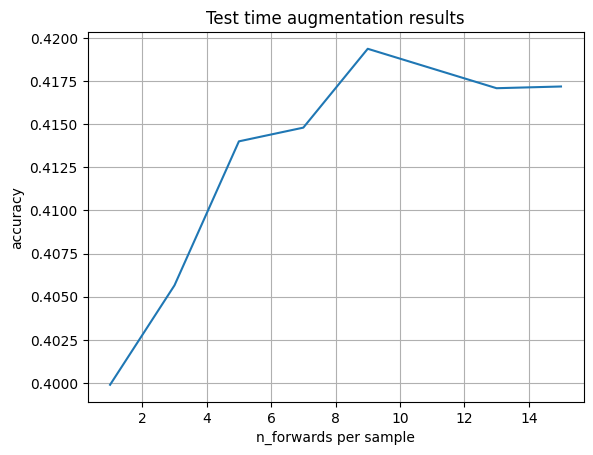

In [50]:
plt.plot(n_forwards, tta_accuracy)
plt.grid()
plt.xlabel('n_forwards per sample')
plt.ylabel('accuracy')
plt.title('Test time augmentation results')

In [28]:
tta_accuracy

[0.39988057324840764,
 0.39241640127388533,
 0.4030652866242038,
 0.4029657643312102,
 0.40535429936305734,
 0.40744426751592355,
 0.40794187898089174]

In [27]:
n_forwards

[1, 3, 5, 7, 9, 13, 15]

Normally you should get 1-2% improvement of accuracy here.

## What's next?
Introducing of residual blocks played a big role in deep learning and allowed to train deep (and I mean really [DEEP](https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua#L2)) networks. Many modern architectures include such layer or its variation. For deeper understanding of influence of skip connections you can read the following papers:
1. ["Residual Networks Behave Like Ensembles of
Relatively Shallow Networks"](https://arxiv.org/pdf/1605.06431.pdf) - interesting point of view on residual blocks showing that statement "skip connections solves vanishing gradients problem" is ambigious in some way
2. ["Identity Mappings in Deep Residual Networks"](https://arxiv.org/pdf/1603.05027.pdf) ([short summary](https://towardsdatascience.com/resnet-with-identity-mapping-over-1000-layers-reached-image-classification-bb50a42af03e)) - study and comparison of different residual blocks variations showing that preserving "identity path" through the network improves quality
3. ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/pdf/1712.09913.pdf) - some attempts on loss function visualization showed how skip-connections affect loss landscape